In [1]:
%pip install openai graphrag pandas requests python-dotenv langchain numpy tiktoken matplotlib scikit-learn pyyaml
from IPython.display import clear_output ; clear_output()

In [3]:
from dotenv import load_dotenv
import os
load_dotenv()

is_azure = (
  os.getenv("AZURE_OPENAI_ENDPOINT", default="") != "" and
  os.getenv("OPENAI_API_KEY", default="") == ""
)

GPT_4_O_MODEL_NAME = os.getenv("GPT_4_O_MODEL_NAME", default="gpt-4o")
TEXT_EMBEDDING_3_LARGE_MODEL_NAME = os.getenv("TEXT_EMBEDDING_3_LARGE_MODEL_NAME", default="text-embedding-3-large")

if is_azure:
  AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
  AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
  AZURE_OPENAI_API_VERSION = "2024-05-01-preview"
  from openai import AzureOpenAI
  oai = AzureOpenAI(azure_endpoint=AZURE_OPENAI_ENDPOINT, api_key=AZURE_OPENAI_API_KEY, api_version=AZURE_OPENAI_API_VERSION)
else:
  OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
  from openai import OpenAI
  oai = OpenAI(api_key=OPENAI_API_KEY)

In [4]:
import requests
import os

if not os.path.exists('data'): os.makedirs('data')

if not os.path.exists('data/french_revolution.md'):
  french_revolution = requests.get("https://r.jina.ai/https://en.wikipedia.org/wiki/French_Revolution").text.split('\nSee also')[0]
  with open('data/french_revolution.md', 'w') as f:
    f.write(french_revolution)
else:
  with open('data/french_revolution.md', 'r') as f:
    french_revolution = f.read()

print(french_revolution)

Title: French Revolution

URL Source: https://en.wikipedia.org/wiki/French_Revolution

Published Time: 2001-10-18T00:19:10Z

Markdown Content:
Jump to content
Main menu
Search
Appearance
Create account
Log in
Personal tools
Toggle the table of contents
French Revolution
158 languages
Article
Talk
Read
View source
View history
Tools
From Wikipedia, the free encyclopedia
For other uses, see French Revolution (disambiguation).
French Revolution
Part of the Atlantic Revolutions

The Storming of the Bastille, 14 July 1789

Date	5 May 1789 – 9 November 1799
(10 years, 6 months, and 4 days)
Location	Kingdom of France
Outcome	
Abolition of the Ancien régime and creation of constitutional monarchy
Proclamation of the French First Republic in September 1792
Reign of Terror and execution of Louis XVI
French Revolutionary Wars
Establishment of the French Consulate in November 1799

The French Revolution[a] was a period of political and societal change in France that began with the Estates General 

In [5]:
from langchain.text_splitter import MarkdownTextSplitter
import pandas as pd

if not os.path.exists('data/embeddings.parquet'):
  embeddings = pd.DataFrame(columns=['Topic', 'Text', 'Embedding'])

  splitter = MarkdownTextSplitter(chunk_size=500, chunk_overlap=250)

  chunks = splitter.split_text(french_revolution)
  chunk_embeddings = oai.embeddings.create(
    input=chunks,
    model=TEXT_EMBEDDING_3_LARGE_MODEL_NAME
  )
  for i, chunk in enumerate(chunks):
    try:
      topic = oai.chat.completions.create(
        model=GPT_4_O_MODEL_NAME,
        messages=[
          {
            "role": "system",
            "content": ("Read the user-provided text carefully and output its topic as a short sentence. "
                        "For example: 'Key events in the life of George Washington', 'Inflation in the Weimar republic'. "
                        "Do not add any additional text such as punctuation, markup, or quoting. Only output the topic.")},
          {"role": "user", "content": chunk}
        ],
        max_tokens=23,
        temperature=0.5,
      ).choices[0].message.content
    except Exception:
      pass
    embeddings.loc[len(embeddings)] = [topic or chunk[:23], chunk, chunk_embeddings.data[i].embedding]
  embeddings.to_parquet('data/embeddings.parquet')
else:
  embeddings = pd.read_parquet('data/embeddings.parquet')

embeddings

,Topic,Text,Embedding
0,French Revolution,Title: French Revolution\n\nURL Source: https:...,"[-0.02485630474984646, 0.0026923343539237976, ..."
1,Key events of the French Revolution,"The Storming of the Bastille, 14 July 1789\n\n...","[-0.005255864467471838, 0.0037901357281953096,..."
2,The French Revolution and its impact on modern...,The French Revolution[a] was a period of polit...,"[-0.027185581624507904, -0.016875529661774635,..."
3,Causes and early events of the French Revolution,Its causes are generally agreed to be a combin...,"[-0.020989766344428062, -0.024809090420603752,..."
4,Key events in the early stages of the French R...,which was converted into a National Assembly i...,"[-0.009496822953224182, -0.017249926924705505,..."
...,...,...,...
296,Alphonse Aulard's contributions to the study o...,evidence.[266][267] Alphonse Aulard (1849–1928...,"[-0.0005632034735754132, 0.021342121064662933,..."
297,Marxist socio-economic analysis of the French ...,Socio-economic analysis and a focus on the exp...,"[-0.003857595380395651, 0.007019456941634417, ..."
298,Alfred Cobban's critique of Jacobin-Marxist in...,Alfred Cobban challenged Jacobin-Marxist socia...,"[0.004117575474083424, 0.00744161382317543, -0..."
299,Political decisions and radicalization during ...,"In their 1965 work, La Revolution française, F...","[0.017132386565208435, 0.012499384582042694, -..."


In [6]:
import numpy as np
import tiktoken

def cosine_similarity(vector1, vector2):
  dot_product = np.dot(vector1, vector2)
  norm1 = np.linalg.norm(vector1)
  norm2 = np.linalg.norm(vector2)
  similarity = dot_product / (norm1 * norm2)
  return similarity

tokenizer = tiktoken.encoding_for_model('gpt-4o')

def embeddings_search(query, max_tokens=10000, k=100, min_similarity=0.2):
  query_embedding = oai.embeddings.create(
    input=[query],
    model=TEXT_EMBEDDING_3_LARGE_MODEL_NAME
  ).data[0].embedding
  results = embeddings.copy()
  results['Similarity'] = results['Embedding'].apply(lambda x: cosine_similarity(x, query_embedding))
  results = results.sort_values(by='Similarity', ascending=False).head(k)
  results = results[results['Similarity'] >= min_similarity]
  results['Tokens'] = results['Text'].apply(lambda txt: len(tokenizer.encode(txt)))
  while results['Tokens'].sum() > max_tokens:
    results = results[:-1]
  return results

In [7]:
embeddings_search('Robespierre', max_tokens=100000, k=100, min_similarity=0.5)

,Topic,Text,Embedding,Similarity,Tokens
152,Downfall of Robespierre during the French Revo...,Robespierre responded by refusing to attend Co...,"[0.01744542457163334, -0.02923157624900341, -0...",0.584795,95
142,Georges Danton; Robespi,Georges Danton; Robespierre's close friend and...,"[0.013962339609861374, -0.0019082281505689025,...",0.550633,24
154,After the Convention au,"After the Convention authorised his arrest, he...","[0.040064550936222076, -0.02160113863646984, -...",0.515789,104
153,The downfall of Robespierre during the French ...,certain death sentence if confirmed. When he r...,"[0.024821629747748375, -0.008778694085776806, ...",0.512442,100


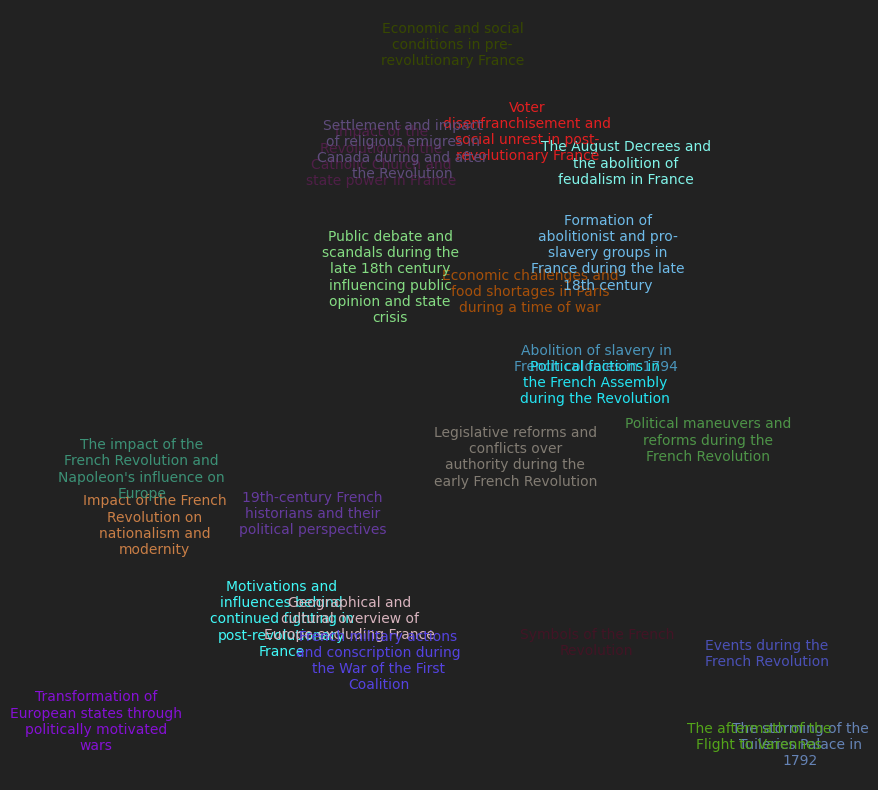

In [110]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import textwrap
import random

embeddings_sample = embeddings.sample(23)

pca = PCA(n_components=2)
topics = embeddings_sample['Topic'].tolist()
reduced_embeddings = pca.fit_transform(np.array(embeddings_sample['Embedding'].tolist()))

plt.figure(figsize=(10, 10))
plt.gcf().set_facecolor('#222222')
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], marker='')
for i, topic in enumerate(topics):
    plt.annotate(
      '\n'.join(textwrap.wrap(topic, width=23)),
      (reduced_embeddings[i, 0], reduced_embeddings[i, 1]),
      fontsize=10, ha='center', va='center',
      color="#" + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)]),
    )
plt.axis('off')
plt.show()

In [17]:
import yaml

if not os.path.exists('data/graphrag'):
  !python -m graphrag.index --init --root data/graphrag

with open('data/graphrag/settings.yaml', 'r') as f:
  settings_yaml = yaml.load(f, Loader=yaml.FullLoader)
settings_yaml['llm']['model'] = GPT_4_O_MODEL_NAME
settings_yaml['llm']['api_key'] = AZURE_OPENAI_API_KEY if is_azure else OPENAI_API_KEY
settings_yaml['llm']['type'] = 'azure_openai_chat' if is_azure else 'openai_chat'
settings_yaml['embeddings']['llm']['api_key'] = AZURE_OPENAI_API_KEY if is_azure else OPENAI_API_KEY
settings_yaml['embeddings']['llm']['type'] = 'azure_openai_embedding' if is_azure else 'openai_embedding'
settings_yaml['embeddings']['llm']['model'] = TEXT_EMBEDDING_3_LARGE_MODEL_NAME
if is_azure:
  settings_yaml['llm']['api_version'] = AZURE_OPENAI_API_VERSION
  settings_yaml['llm']['deployment_name'] = GPT_4_O_MODEL_NAME
  settings_yaml['llm']['api_base'] = AZURE_OPENAI_ENDPOINT
  settings_yaml['embeddings']['llm']['api_version'] = AZURE_OPENAI_API_VERSION
  settings_yaml['embeddings']['llm']['deployment_name'] = TEXT_EMBEDDING_3_LARGE_MODEL_NAME
  settings_yaml['embeddings']['llm']['api_base'] = AZURE_OPENAI_ENDPOINT

with open('data/graphrag/settings.yaml', 'w') as f:
  yaml.dump(settings_yaml, f)

if not os.path.exists('data/graphrag/input'): os.makedirs('data/graphrag/input')
!cp data/french_revolution.md data/graphrag/input/french_revolution.txt

!python -m graphrag.index --root ./data/graphrag

🚀 Reading settings from data/graphrag/settings.yaml
⠹ GraphRAG Indexer 
⠹ GraphRAG Indexer les loaded (0 filtered) ━━━━━━ 100% 0:00:… 0:00:…
├── Loading Input (text) - 1 files loaded (0 filtered) ━━━━━━ 100% 0:00:… 0:00:…
⠹ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (0 filtered) ━━━━━━ 100% 0:00:… 0:00:…
⠹ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (0 filtered) ━━━━━━ 100% 0:00:… 0:00:…
⠹ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (0 filtered) ━━━━━━ 100% 0:00:… 0:00:…
⠹ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (0 filtered) ━━━━━━ 100% 0:00:… 0:00:…
└── create_base_text_units
⠸ GraphRAG Indexer ━━━━━━━━━━━━━━━━━   0% -:--:-- 0:00:00
├── Loading Input (text) - 1 files loaded (0 filtered) ━━━━━━ 100% 0:00:… 0:00:…
⠸ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (0 filtered) ━━━━━━ 100% 0:00:… 0:00:…
⠸ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (0 filtered) ━━━━━━ 100% 0:00:… 0:00:…
⠸ Grap